In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Extract features

In [2]:
class FeatureExtractor(object):
    
    
    def _color_hist(self, img, nbins=32, bins_range=(0, 256), visual=False):
        '''
        Get histogram of color information in each channel
        '''
        # Compute each channel
        hist_0 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        hist_1 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        hist_2 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        
        # Generate histogram center
        if(visual):
            hist_edges = hist_0[1]
            hist_enters = (hist_edges[0:len(hist_edges)-1] + hist_edges[1:])/2
            
        hist_features = np.concatenate((hist_0[0], hist_1[0], hist_2[0]))
        
        if(visual):
            return hist_0, hist_1, hist_2, hist_enters, hist_features
        else:
            return hist_features
        
    def _bin_spatial(self, img, size=(32, 32)):
        '''
        resize the image and flatten the features
        '''
        color1 = cv2.resize(img[:,:,0], size).ravel()
        color2 = cv2.resize(img[:,:,1], size).ravel()
        color3 = cv2.resize(img[:,:,2], size).ravel()
        return np.hstack((color1, color2, color3))
        
    def _hog(self, img, orient=9, pixs_per_cell=8, cells_per_block=2, feature_vec=True, hog_channel=0):
        '''
        Wrapper class of skimage.hog
        '''
        hog_features = hog(img[:,:,hog_channel], orientations=orient, 
                           pixels_per_cell=(pixs_per_cell, pixs_per_cell),
                           cells_per_block=(cells_per_block, cells_per_block), 
                           block_norm= 'L2-Hys',
                           transform_sqrt=False,
                           feature_vector=feature_vec)
        return hog_features
    
    def _hog_vis(self, img, orient=9, pixs_per_cell=8, cells_per_block=2, vis = True,feature_vec=True, hog_channel=0):
        
        
        hog_features, hog_image = hog(img[:,:,hog_channel], orientations=orient, 
                   pixels_per_cell=(pixs_per_cell, pixs_per_cell),
                   cells_per_block=(cells_per_block, cells_per_block), 
                   block_norm= 'L2-Hys',
                   transform_sqrt=False,
                   visualise=True,
                   feature_vector=feature_vec)
        
        return hog_features, hog_image
        
    def extract_features(self, image_paths, color_space='RGB',
                         use_spatial_bin = True,
                         use_color_hist = True,
                         use_hog = True,
                         orient=9,
                         pixs_per_cell=8,
                         cells_per_block=2,
                         hog_channel=0,
                         spatial_size=(32,32),
                         hist_bins=32, 
                         hist_range=(0, 256)):
        '''
        For image PATHS
        Warper of _bin_spatial, _color_hist, and _hog
        '''

        all_features = []
        # Convert the images to specify color space
        for image_path in image_paths:
            img = mpimg.imread(image_path)
            
            features = [] # temp
            if color_space == 'RGB':
                feature_img = np.copy(img)
            elif color_space == 'HSV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YCrCb':
                 feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
                
            if(use_spatial_bin):
                bin_feature = self._bin_spatial(feature_img, size=spatial_size)
                features.append(bin_feature)
            if(use_color_hist):
                color_hist_feature = self._color_hist(feature_img, nbins=hist_bins,
                                                      bins_range=hist_range)
                features.append(color_hist_feature)
            if(use_hog):
                if hog_channel == 'ALL':
                    hog_features = []
                    for i in range(img.shape[2]): # R G B
                        hog_features.append(self._hog(feature_img, hog_channel=i))
                    hog_features = np.ravel(hog_features) # unroll to 1D 
                else:
                    hog_features = self._hog(feature_img, hog_channel=hog_channel)
                
                features.append(hog_features)
        
            all_features.append(np.concatenate(features))
        
        return all_features
        
    def extract_img_features(self, img, color_space='RGB',
                         use_spatial_bin = True,
                         use_color_hist = True,
                         use_hog = True,
                         orient=9,
                         pixs_per_cell=8,
                         cells_per_block=2,
                         hog_channel=0,
                         spatial_size=(32,32),
                         hist_bins=32, 
                         hist_range=(0, 256)):
        '''
        For one image
        Warper of _bin_spatial, _color_hist, and _hog
        '''
        # Convert the images to specify color space
        features = [] 
        if color_space == 'RGB':
            feature_img = np.copy(img)
        elif color_space == 'HSV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

        if(use_spatial_bin):
            bin_feature = self._bin_spatial(feature_img, size=spatial_size)
            features.append(bin_feature)
        if(use_color_hist):
            color_hist_feature = self._color_hist(feature_img, nbins=hist_bins,
                                                  bins_range=hist_range)
            features.append(color_hist_feature)
            
        if(use_hog):
            if hog_channel == 'ALL':
                hog_features = []
                for i in range(img.shape[2]): # R G B
                    hog_features.append(self._hog(feature_img, hog_channel=i))
                hog_features = np.ravel(hog_features) # unroll to 1D 
            else:
                hog_features = self._hog(feature_img, hog_channel=hog_channel)
            features.append(hog_features)

        return np.concatenate(features)

## Unit test 

In [3]:
FE = FeatureExtractor()
test_img = mpimg.imread('test_images/image0007.png')
hog_feature, hog_img = FE._hog_vis(img=test_img)

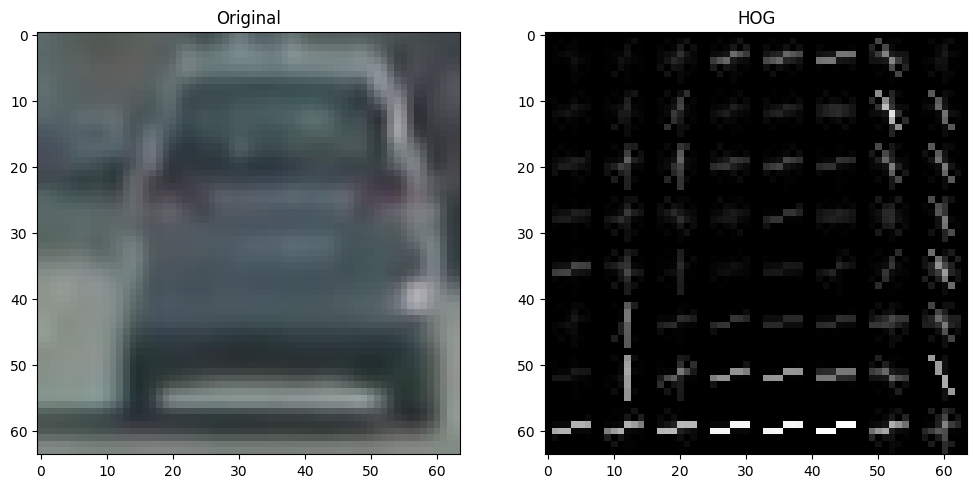

In [4]:
plt.figure(figsize=(12,8), dpi=100)
plt.subplot(121)
plt.title('Original')
plt.imshow(test_img)
plt.subplot(122)
plt.title('HOG')
plt.imshow(hog_img,'gray')

## Data preprocessing

In [5]:
class DataScientist(object):
    '''
    Clean up the dataset for easy acess
    * Merge image paths
    * Save scaler 
    * Save train_valid_dataset
    '''
    
    def __init__(self):
        self.fe = FeatureExtractor() # Feature extracotr as a component
        self.scaler = None
        self.car_paths = []
        self.nocar_paths = []
    
    def merge_dataset(self):
        '''
        Merge seperated dataset
        '''
        
        car1 = glob.glob('../Vehicle-Detection-Dataset/vehicles/GTI_Far/*.png')
        car2 = glob.glob('../Vehicle-Detection-Dataset/vehicles/GTI_Left/*.png')
        car3 = glob.glob('../Vehicle-Detection-Dataset/vehicles/GTI_MiddleClose/*.png')
        car4 = glob.glob('../Vehicle-Detection-Dataset/vehicles/GTI_Right/*.png')
        car5 = glob.glob('../Vehicle-Detection-Dataset/vehicles/KITTI_extracted/*.png')
        self.car_paths = car1 + car2 + car3 + car4 +car5 # Buffer to member variable
        
        nocar1 = glob.glob('../Vehicle-Detection-Dataset/non-vehicles/Extras/*.png')
        nocar2 = glob.glob('../Vehicle-Detection-Dataset/non-vehicles/GTI/*.png')
        self.nocar_paths = nocar1 + nocar2 # Buffer to member variable
        
        print('Dataset contains {} car images'.format(len(self.car_paths)))
        print('Dataset contains {} nocar images'.format(len(self.nocar_paths)))
    
    def extract_features(self):
        '''
        Use class FeatureExtractor
        '''
        car_features = self.fe.extract_features(image_paths=self.car_paths, hog_channel='ALL', color_space='YCrCb')
        print('car_features shape = {}'.format(np.asarray(car_features).shape))
        nocar_features = self.fe.extract_features(image_paths=self.nocar_paths, hog_channel='ALL', color_space='YCrCb')
        print('nocar_features shape = {}'.format(np.asarray(nocar_features).shape))
        # same col -> vstack
        features = np.vstack((car_features, nocar_features)).astype(np.float64)
        print('features shape = {}'.format((features).shape))
        
        # Feature scaling [BUGG!!!!!!]
        self.scaler = StandardScaler().fit(features) # Scale need to be stored!
        self.features = self.scaler.transform(features)
        # same row -> hstack
        self.labels = np.hstack([np.ones(len(car_features)), np.zeros(len(nocar_features))])
    
    def save_scaler(self, fname='scaler'):
        '''
        Save the scaler as pickle for easy access
        Must be called after 'self.extract_features'
        '''
        with open(fname, 'wb') as f:
            pickle.dump(self.scaler, f)
            print('scaler is saved!')
  
    def train_valid_split(self, test_size=0.2):
        '''
        Wraper calss for train_test_split and save the result as pickle for easy access
        '''
        X_train, X_valid, y_train, y_valid = train_test_split(self.features,
                                                              self.labels,
                                                              test_size= test_size)
        train_valid_dataset = {}
        train_valid_dataset['X_train'] = X_train
        train_valid_dataset['y_train'] = y_train
        train_valid_dataset['X_valid'] = X_valid
        train_valid_dataset['y_valid'] = y_valid
        with open('train_valid_dataset', 'wb') as f:
            pickle.dump(train_valid_dataset, f)
            print('Save the features into train_valid_dataset!')
            
    

### This cell needs to be executed only once 
Due to the size of pickle file of train_valid_dataset is too large (684MB), the GitHub repository will not contain it!

In [6]:
# This cell only need to execute once
DS = DataScientist()
DS.merge_dataset() 
DS.extract_features() 
DS.save_scaler()
DS.train_valid_split(test_size=0.3) 

Dataset contains 8792 car images
Dataset contains 8968 nocar images
car_features shape = (8792, 8460)
nocar_features shape = (8968, 8460)
features shape = (17760, 8460)
scaler is saved!
Save the features into train_valid_dataset!


In [7]:
class VehicleClassifier(object):
    '''
    * specify the classifier
    * train/test the classifier
    '''
    
    def __init__(self):
        self.clf = LinearSVC() # use SVM
        self.fe = FeatureExtractor() # feature extracotr as a component
        self.scaler = None
        self.test_valid_dataset = None
        self.contains_model = False # A flag for user error handling
        self._load_dataset() # Call during constructed
        
    def _load_dataset(self, fname='train_valid_dataset'):
        '''
        Buffer the splited dataset
        The user need to load the data set first before execute further training
        '''
        with open(fname, 'rb') as f:
            self.test_valid_dataset = pickle.load(f)
            print('The train_valid_dataset is buffered!')
        
        with open('scaler', 'rb') as f:
            self.scaler = pickle.load(f)
            print('Scaler is loaded')
           
    def train_model_and_save_as_pickle(self, fname = 'trained_model\SVM'):
        '''
        Train the model, and save it as pickle for easy access
        '''
        
        if(self.test_valid_dataset == None): print('Please call the load_dataset first!') # User error handling
        X_train = self.test_valid_dataset['X_train']
        y_train = self.test_valid_dataset['y_train']
        self.clf.fit(X_train, y_train)
        self.contains_model = True;
        
        # Save the model as pickle -> hard-coded the filename here
        with open(fname, 'wb') as f:
            pickle.dump(self.clf, f);
            print('Save the trained model into {}'.format(fname))
           
    def load_trained_model(self, fname='trained_model\SVM'):
        '''
        Specify the trained model address
        '''
        
        with open(fname, 'rb') as f:
            self.clf = pickle.load(f)
            print('Load model from {}'.format(fname))
            self.contains_model = True;
            
    def valid(self):
        '''
        Valid model with stored validation dataset
        '''
        
        if(self.test_valid_dataset == None): print('Please call the load_dataset first!') # User error handling
        X_valid = self.test_valid_dataset['X_valid']
        y_valid = self.test_valid_dataset['y_valid']
        valid_acc = self.clf.score(X_valid, y_valid)
        print('The valid accuracy is {}%'.format(valid_acc))
    
    def predict_with_paths(self, img_paths):
        '''
        Predict the new data
        img_path: A list of paths to desired imag"
        '''
        if(self.contains_model == False): print('Please train or load a model first!') # User error handling
        
        result = []
        features = self.fe.extract_features(img_paths, hog_channel='ALL', color_space='YCrCb')
        
        # scale the features!!!
        features = self.scaler.transform(features)
        
        result.append(self.clf.predict(features))
        return result
    
    def predict_with_features(self, features):
        '''
        Predict the new data
        features: features from "FeaturesExtracot"
        '''
        if(self.contains_model == False): print('Please train or load a model first!') # User error handling
        result = []
        features = self.scaler.transform(features) 
        result.append(self.clf.predict(features))
        return result
              

In [8]:
cls = VehicleClassifier()

The train_valid_dataset is buffered!
Scaler is loaded


In [26]:
cls.train_model_and_save_as_pickle('trained_models\SVM') # Execute once

Save the trained model into trained_models\SVM


In [27]:
cls.load_trained_model('trained_models\SVM')
cls.valid()

Load model from trained_models\SVM
The valid accuracy is 0.9823573573573574%


### Validation accuracy
**SVM classifier: 0.957%**

Use predict function, but this is relatively stupid becuase I used the one of the original dataset.
In this case just an **Unit test**

In [28]:
new_image_paths = ['test_images/image0007.png', 'test_images\image1.png']
cls.predict_with_paths(new_image_paths)

[array([ 1.,  0.])]

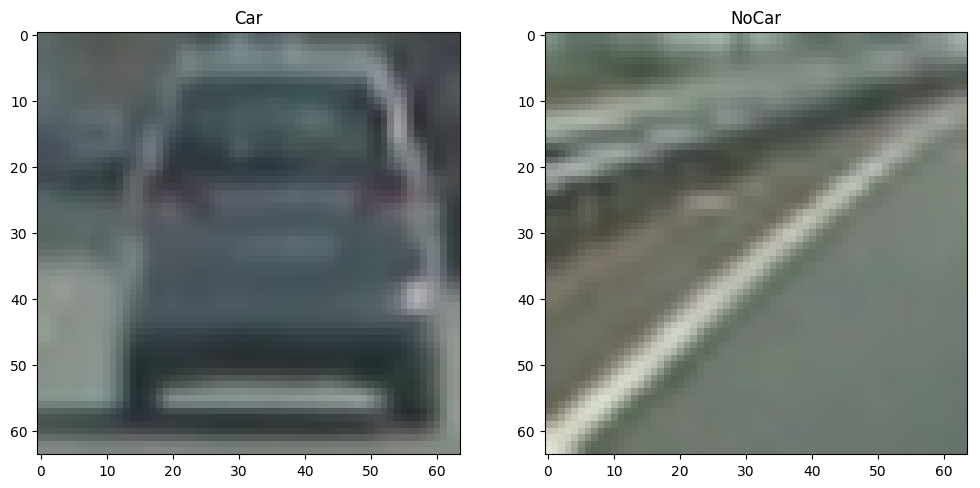

In [29]:
image0007 = mpimg.imread(new_image_paths[0])
image1 = mpimg.imread(new_image_paths[1])
plt.figure(figsize=(12,8),dpi=100)
plt.subplot(121)
plt.title('Car')
plt.imshow(image0007)
plt.subplot(122)
plt.title('NoCar')
plt.imshow(image1)



## Sliding Windows

### Draw function

In [30]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Visualization

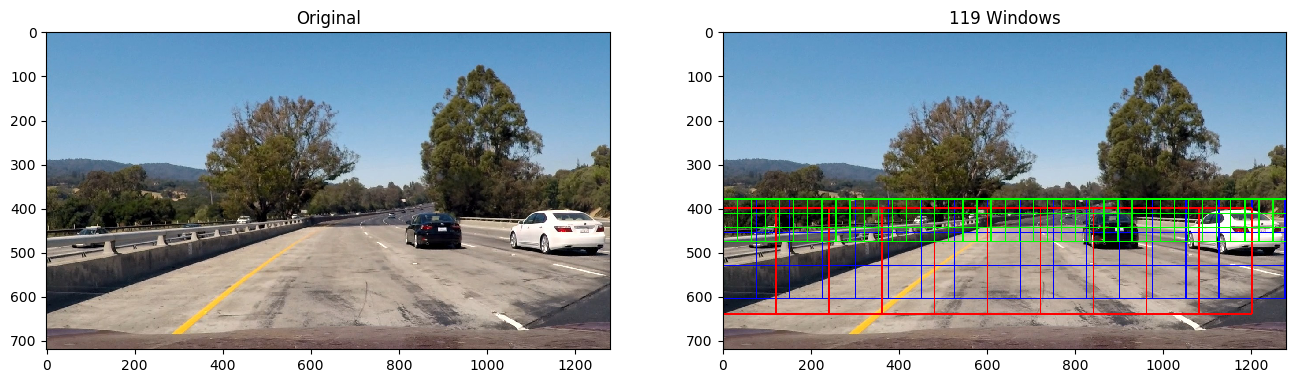

In [31]:
test_image = mpimg.imread('test_images/test1.jpg')

# Need to draw differnet scale of windows in order to let the feature extraction search differnt ratio
windows_general = slide_window(test_image, y_start_stop=[380, 650],  xy_window=(150, 150), xy_overlap=(0.5, 0.5))
windows_bottom = slide_window(test_image, y_start_stop=[400, 650], xy_window=(240, 240), xy_overlap=(0.5, 0.5))
windows_top = slide_window(test_image, y_start_stop=[380,500], xy_window=(64, 64), xy_overlap=(0.5, 0.5))

windows = windows_general + windows_bottom + windows_top

test_image_windows = draw_boxes(test_image, windows_general)
test_image_windows = draw_boxes(test_image_windows, windows_bottom, color=(255, 0, 0))
test_image_windows = draw_boxes(test_image_windows, windows_top, color= (0, 255, 0))

plt.figure(figsize=(16,8), dpi=100)
plt.subplot(121)
plt.title('Original')
plt.imshow(test_image)
plt.subplot(122)
plt.title('{} Windows'.format(len(windows)))
plt.imshow(test_image_windows)

In [32]:
hog_feature, hog_img = FE._hog_vis(img=test_image)

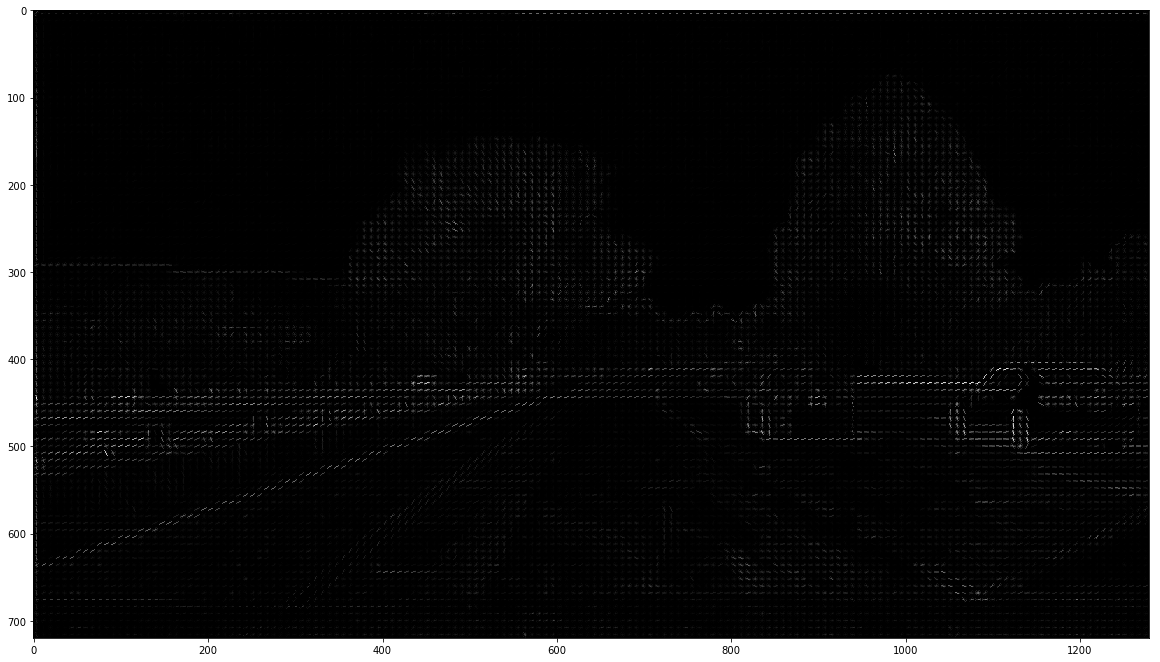

In [33]:
plt.figure(figsize=(20,18))
plt.imshow(hog_img, 'gray')

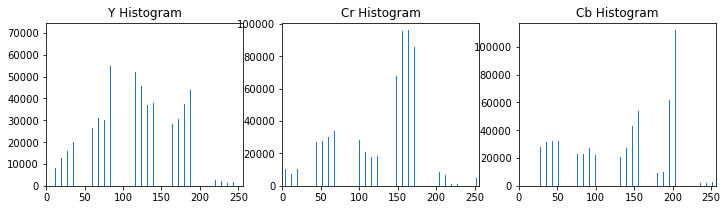

In [34]:
hist_0, hist_1, hist_2, hist_enters, hist_features = FE._color_hist(test_image, visual=True)
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(hist_enters, hist_0[0])
plt.xlim(0, 256)
plt.title('Y Histogram')
plt.subplot(132)
plt.bar(hist_enters, hist_1[0])
plt.xlim(0, 256)
plt.title('Cr Histogram')
plt.subplot(133)
plt.bar(hist_enters, hist_2[0])
plt.xlim(0, 256)
plt.title('Cb Histogram')

In [35]:
class VehicleDetector(object):
    '''
    Host class for the vehicle dection
    '''
    
    def __init__(self):
        self.clf = VehicleClassifier() # classifier
        self.clf.load_trained_model(fname='trained_models\SVM')
        self.fe = FeatureExtractor() # Feature extractor
            
    
    def search_windows(self, img, windows):
        '''
        Takes the specified windows 
        '''
        
        detections = []
        for window in windows:
            # Extract the area from original image
            img_resize = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            
            # Extract features
            features = self.fe.extract_img_features(img_resize, hog_channel='ALL', color_space='YCrCb')
            # Predict 
            pred = self.clf.predict_with_features((features).reshape(1, -1)) # The scaler is interally called!!!!
            if pred[0] == 1: # Car!
                detections.append(window)
        return detections
    
    def find_car(self, img, ystart, ystop, scale, orient, pixs_per_cell, cells_per_block):
        '''
        Apply sub-sampling for HOG.
        '''
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255
        
        img_tosearch = img[ystart:ystop,:,:] # ROI
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrains_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1]// pixs_per_cell) - cells_per_block + 1
        nyblocks = (ch1.shape[0]// pixs_per_cell) - cells_per_block + 1 
        nfeat_per_block = orient*cells_per_block**2 # number of features
        
        # 64 was the original smappling rate, 8  cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window//pixs_per_cell) - cells_per_block + 1
        cells_per_step = 2 # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
        
        # Compute individual channel HOG features for the entire image
        hog1 = self.fe._hog(ctrains_tosearch, feature_vec=False, hog_channel=0)
        hog2 = self.fe._hog(ctrains_tosearch, feature_vec=False, hog_channel=1)
        hog3 = self.fe._hog(ctrains_tosearch, feature_vec=False, hog_channel=2)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                # Sub sample the HOG
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)) # same row!
                
                xleft = xpos*pixs_per_cell
                ytop = ypos*pixs_per_cell
                
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64)) # from our x-y coordinate to iamge coordinate
                
                # Get color features 
                spatial_features = self.fe._bin_spatial(subimg)
                hist_features = self.fe._color_hist(subimg)
                
                #features = []
                #features.append(spatial_features)
                #features.append(hist_features)
                #features.append(hog_features)
                #features = np.concatenate(features)
                
                features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                pred = self.clf.predict_with_features(features) # re scale interally!
                
                if pred == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
        return draw_img
    
    def get_heatmap(self, img, windows_list, threshold=5):
        '''
        Merge overlaped windows
        '''
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for window in windows_list:
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
            
        heatmap[heatmap <= threshold] = 0
        return heatmap
    
    


In [36]:
feat1 = [1,2,3]
feat2 = [4,5]
feat3 = [6,7,8,9]

combine = np.hstack((feat1, feat2, feat3)).reshape(1,-1)
combine.shape


#combine

(1, 9)

In [37]:
detector = VehicleDetector()

The train_valid_dataset is buffered!
Scaler is loaded
Load model from trained_models\SVM


In [38]:
detected_windows = detector.search_windows(test_image, windows)
detected_windows_img = draw_boxes(test_image, detected_windows)

In [39]:
heatmap = detector.get_heatmap(detected_windows_img, detected_windows, 5)

In [40]:
from scipy.ndimage.measurements import label
labels = label(heatmap)

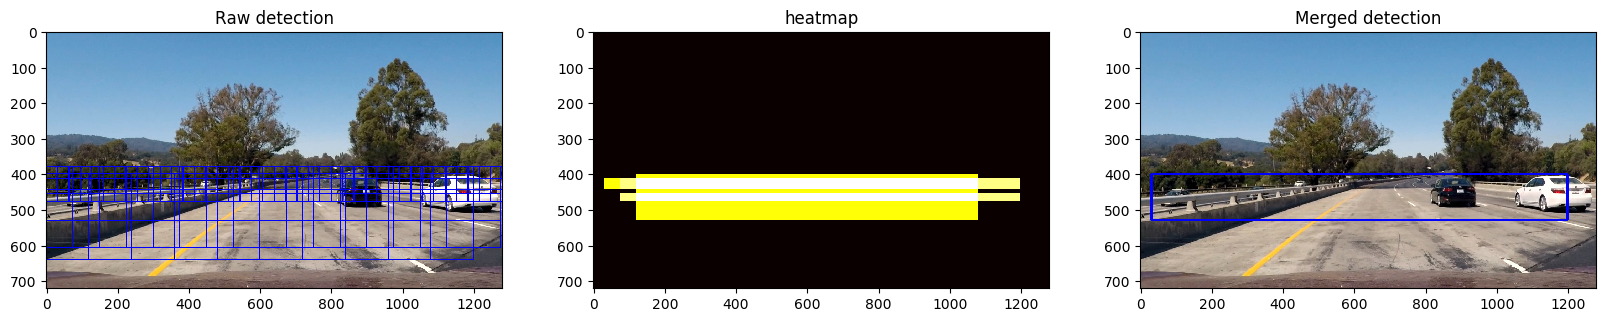

In [41]:
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

plt.figure(figsize=(20,16), dpi=100)
plt.subplot(131)
plt.title('Raw detection')
plt.imshow(detected_windows_img)

plt.subplot(132)
plt.title('heatmap')
plt.imshow(heatmap, cmap='hot')

plt.subplot(133)
plt.title('Merged detection')
plt.imshow(draw_img)


In [42]:
sub_sampling_img = detector.find_car(test_image, ystart = 400, ystop=656, scale=1.5, orient=9, pixs_per_cell=8, cells_per_block=2)


ValueError: operands could not be broadcast together with shapes (1,7704) (8460,) (1,7704) 

In [ ]:
plt.figure(figsize=(16,10))
plt.imshow(sub_sampling_img)